<a href="https://colab.research.google.com/github/Zobia12/EEG_Based_Human_Emotion_Recognition_Using_Deep_Learning/blob/main/EEG_based_Emotion_Recognition_Using_KNN_model(with_32_channels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
import numpy as np
import seaborn as sns

In [134]:
import pickle
import numpy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [135]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [136]:
# data_preprocessed_python
os.getcwd()
os.chdir('/content/drive/My Drive')

In [137]:
nLabel, nTrial, nUser, nChannel, nTime  = 4, 40, 32, 40, 8064
no_of_users=32
def convertData():
    print("Program started"+"\n")
    fout_data = open("/content/drive/My Drive/leading_ai/try/features_raw.dat",'w')
    fout_labels0 = open("/content/drive/My Drive/leading_ai/try/labels_0.dat",'w')
    fout_labels1 = open("/content/drive/My Drive/leading_ai/try/labels_1.dat",'w')
    fout_labels2 = open("/content/drive/My Drive/leading_ai/try/labels_2.dat",'w')
    fout_labels3 = open("/content/drive/My Drive/leading_ai/try/labels_3.dat",'w')
    for i in range(no_of_users):  #nUser #4, 40, 32, 40, 8064 4 labels, 40 sample for each user, 32 such user, 40 electrode, 8064*40 features
        if(i%1 == 0):
            if i < 10:
                name = '%0*d' % (2,i+1)
            else:
                name = i+1
        fname = "/content/drive/My Drive/leading_ai/try/s"+str(name)+".dat"     
        f = open(fname, 'rb')                 #Read the file in Binary mode
        x = pickle.load(f, encoding='latin1')
        print(fname)                          
    	
        for tr in range(nTrial):
            if(tr%1 == 0):
                for dat in range(nTime):
                    if(dat%32 == 0):
                        for ch in range(nChannel):
                            fout_data.write(str(x['data'][tr][ch][dat]) + " ");
                fout_labels0.write(str(x['labels'][tr][0]) + "\n");
                fout_labels1.write(str(x['labels'][tr][1]) + "\n");
                fout_labels2.write(str(x['labels'][tr][2]) + "\n");
                fout_labels3.write(str(x['labels'][tr][3]) + "\n");
                fout_data.write("\n");
    fout_labels0.close()
    fout_labels1.close()
    fout_labels2.close()
    fout_labels3.close()
    fout_data.close()
    print("\n"+"Print Successful")

if __name__ == '__main__':
    convertData()


Program started

/content/drive/My Drive/leading_ai/try/s01.dat
/content/drive/My Drive/leading_ai/try/s02.dat
/content/drive/My Drive/leading_ai/try/s03.dat
/content/drive/My Drive/leading_ai/try/s04.dat
/content/drive/My Drive/leading_ai/try/s05.dat
/content/drive/My Drive/leading_ai/try/s06.dat
/content/drive/My Drive/leading_ai/try/s07.dat
/content/drive/My Drive/leading_ai/try/s08.dat
/content/drive/My Drive/leading_ai/try/s09.dat
/content/drive/My Drive/leading_ai/try/s10.dat
/content/drive/My Drive/leading_ai/try/s11.dat
/content/drive/My Drive/leading_ai/try/s12.dat
/content/drive/My Drive/leading_ai/try/s13.dat
/content/drive/My Drive/leading_ai/try/s14.dat
/content/drive/My Drive/leading_ai/try/s15.dat
/content/drive/My Drive/leading_ai/try/s16.dat
/content/drive/My Drive/leading_ai/try/s17.dat
/content/drive/My Drive/leading_ai/try/s18.dat
/content/drive/My Drive/leading_ai/try/s19.dat
/content/drive/My Drive/leading_ai/try/s20.dat
/content/drive/My Drive/leading_ai/try/s21.

In [138]:
channel = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32] #32 Channels chosen to fit Emotiv Epoch+
band = [4,8,12,16,25,45] #5 bands THETA, ALPHA, ALPHA, BETA, BETA, BETA, GAMMA.
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01','02','03']

data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/content/drive/My Drive/leading_ai/try/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('/content/drive/My Drive/leading_ai/data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/leading_ai/label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('/content/drive/My Drive/leading_ai/data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('/content/drive/My Drive/leading_ai/label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)

training dataset: (46848, 155) (46848, 4)
testing dataset: (11712, 155) (11712, 4)


In [139]:
def onehotencoding0():
    print("Program started"+"\n")
    fout_labels_class = open("/content/drive/My Drive/leading_ai/try/label_class_0.dat",'w')
    
    with open('/content/drive/My Drive/leading_ai/try/labels_0.dat','r') as f:
        for val in f:
            if float(val) > 4.5:
                fout_labels_class.write(str(1) + "\n");
            else:
                fout_labels_class.write(str(0) + "\n");
                
    print("Encoded label 0"+"\n")
if __name__ == '__main__':
    onehotencoding0()

Program started

Encoded label 0



In [140]:
def onehotencoding1():
    print("Program started"+"\n")
    fout_labels_class = open("/content/drive/My Drive/leading_ai/try/label_class_1.dat",'w')
    
    with open('/content/drive/My Drive/leading_ai/try/labels_1.dat','r') as f:
        for val in f:
            if float(val) > 4.5:
                fout_labels_class.write(str(1) + "\n");
            else:
                fout_labels_class.write(str(0) + "\n");
    print("Encoded label 1"+"\n")
if __name__ == '__main__':
    onehotencoding1()

Program started

Encoded label 1



In [141]:
def onehotencoding2():
    print("Program started"+"\n")
    fout_labels_class = open("/content/drive/My Drive/leading_ai/try/label_class_2.dat",'w')
    
    with open('/content/drive/My Drive/leading_ai/try/labels_2.dat','r') as f:
        for val in f:
            if float(val) > 4.5:
                fout_labels_class.write(str(1) + "\n");
            else:
                fout_labels_class.write(str(0) + "\n");
    print("Encoded label 2"+"\n")
if __name__ == '__main__':
    onehotencoding2()

Program started

Encoded label 2



In [142]:
def onehotencoding3():
    print("Program started"+"\n")
    fout_labels_class = open("/content/drive/My Drive/leading_ai/try/label_class_3.dat",'w')
    
    with open('/content/drive/My Drive/leading_ai/try/labels_3.dat','r') as f:
        for val in f:
            if float(val) > 4.5:
                fout_labels_class.write(str(1) + "\n");
            else:
                fout_labels_class.write(str(0) + "\n");
    print("Encoded label 3"+"\n")
if __name__ == '__main__':
    onehotencoding3()

Program started

Encoded label 3



# KNN Classifier in terms of Valence

In [143]:
file_x = '/content/drive/My Drive/leading_ai/try/features_sampled.dat'
file_y = '/content/drive/My Drive/leading_ai/try/label_class_0.dat'
    
X = numpy.genfromtxt(file_x, delimiter=' ')
y = numpy.genfromtxt(file_y, delimiter=' ')

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [144]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

In [145]:
y_predict = model.predict(X_test)
y_pred = model.predict(X_train)

Training_cm = confusion_matrix(y_train, y_pred)
Testing_cm = confusion_matrix(y_test, y_predict)

In [146]:
print("Accuracy score of Valence ")
print(accuracy_score(y_test, y_predict)*100)

Accuracy score of Valence 
56.25


In [147]:
print("Accuracy score of Valence ")
print(accuracy_score(y_train, y_pred)*100)

Accuracy score of Valence 
73.4375


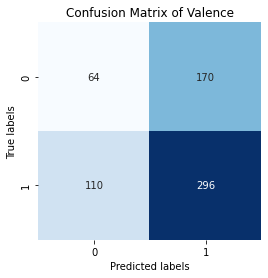

In [149]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(Testing_cm, annot=True,cbar=False, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Valence');

# KNN Classifier in terms of Arousal

In [150]:
file_x = '/content/drive/My Drive/leading_ai/try/features_sampled.dat'
file_y = '/content/drive/My Drive/leading_ai/try/label_class_1.dat'
    
X = numpy.genfromtxt(file_x, delimiter=' ')
y = numpy.genfromtxt(file_y, delimiter=' ')

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [151]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

In [152]:
y_predict = model.predict(X_test)
y_pred = model.predict(X_train)

Training_cm = confusion_matrix(y_train, y_pred)
Testing_cm = confusion_matrix(y_test, y_predict)

In [153]:
print("Accuracy score of Arousal ")
print(accuracy_score(y_test, y_predict)*100)

Accuracy score of Arousal 
57.421875


In [168]:
print("Accuracy score of Arousal ")
print(accuracy_score(y_train, y_pred)*100)

Accuracy score of Arousal 
76.85546875


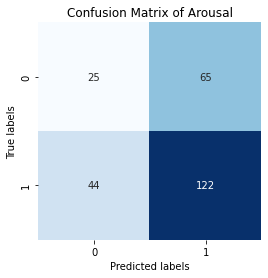

In [155]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(Testing_cm, annot=True,cbar=False, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Arousal'); 

# KNN Classifier in terms of Dominance

In [156]:
file_x = '/content/drive/My Drive/leading_ai/try/features_sampled.dat'
file_y = '/content/drive/My Drive/leading_ai/try/label_class_2.dat'
    
X = numpy.genfromtxt(file_x, delimiter=' ')
y = numpy.genfromtxt(file_y, delimiter=' ')

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

In [158]:
y_predict = model.predict(X_test)
y_pred = model.predict(X_train)

Training_cm = confusion_matrix(y_train, y_pred)
Testing_cm = confusion_matrix(y_test, y_predict)

In [159]:
print("Accuracy score of Dominance ")
print(accuracy_score(y_test, y_predict)*100)

Accuracy score of Dominance 
58.59375


In [160]:
print("Accuracy score of Dominance ")
print(accuracy_score(y_train, y_pred)*100)

Accuracy score of Dominance 
73.33984375


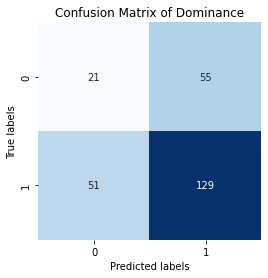

In [161]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(Testing_cm, annot=True,cbar=False, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Dominance'); 

# KNN Classifier in terms of Liking

In [162]:
file_x = '/content/drive/My Drive/leading_ai/try/features_sampled.dat'
file_y = '/content/drive/My Drive/leading_ai/try/label_class_3.dat'
    
X = numpy.genfromtxt(file_x, delimiter=' ')
y = numpy.genfromtxt(file_y, delimiter=' ')

# Split the data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [163]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

KNeighborsClassifier()

In [164]:
y_predict = model.predict(X_test)
y_pred = model.predict(X_train)

Training_cm = confusion_matrix(y_train, y_pred)
Testing_cm = confusion_matrix(y_test, y_predict)

In [165]:
print("Accuracy score of Liking ")
print(accuracy_score(y_test, y_predict)*100)

Accuracy score of Liking 
64.84375


In [166]:
print("Accuracy score of Liking ")
print(accuracy_score(y_train, y_pred)*100)

Accuracy score of Liking 
76.85546875


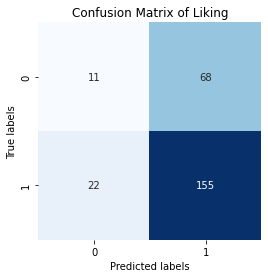

In [167]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.heatmap(Testing_cm, annot=True,cbar=False, fmt='g', ax=ax, cmap=plt.cm.Blues);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix of Liking'); 